In [542]:
# All Imports

# data manipulation
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge 
from sklearn.model_selection import train_test_split
from sklearn import metrics as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import xgboost as xgb 

In [543]:
from google.cloud import bigquery

client = bigquery.Client()

In [ ]:
# select * from models.gs__competition_info
# 33533 = men's basketball for 22-23 season

In [544]:
sql = '''
with
  -- grab relevant game info (note 1 row per game in "gs__game_info")
  game_info as (
    select
      gameId, gameDate, homeId, awayId, homeMarket, awayMarket, homeScore, awayScore, homeScore > awayScore as didHomeWin
    from models.gs__game_info
    where 1 = 1
      and competitionId in (22850, 24996, 27693, 30629, 33533) 
      and homeIsExhib = false
      and awayIsExhib = false
    order by gameDate asc    
  ),
  -- these are the home team's stats heading into each game
  home_season_stats as (
    select
      teamId
      ,lead(gameDate) over (partition by competitionId, teamId, isOffense order by gameDate asc) as nextGameDate
      -- ,gameDate
      ,gp as homeGp
      ,efgPct as homeEfgPct
      ,orbPct as homeOrbPct
      ,tovPct as homeTovPct
      ,ftaRate as homeFtaRate
      ,ortg as homeOrtg
      ,drtg as homeDrtg
      ,netRtg as homeNetRtg
    from models.gs__team_date_stats
    where competitionId in (22850, 24996, 27693, 30629, 33533) and isOffense = true
  ),
  -- these are the away team's stats heading into each game
  away_season_stats as (
    select
      teamId
      ,lead(gameDate) over (partition by competitionId, teamId, isOffense order by gameDate asc) as nextGameDate
      -- ,gameDate
      ,gp as awayGp
      ,efgPct as awayEfgPct
      ,orbPct as awayOrbPct
      ,tovPct as awayTovPct
      ,ftaRate as awayFtaRate
      ,ortg as awayOrtg
      ,drtg as awayDrtg
      ,netRtg as awayNetRtg
    from models.gs__team_date_stats
    where competitionId in (22850, 24996, 27693, 30629, 33533)  and isOffense = true
    order by gameDate asc
  ),
  -- left join the game results onto the prior game date
  tables_joined as (
    select
      a.*
      ,b.* except (teamId, nextGameDate)
      ,c.* except (teamId, nextGameDate)
    from game_info as a
    left join home_season_stats as b on a.gameDate = b.nextGameDate and a.homeId = b.teamId
    left join away_season_stats as c on a.gameDate = c.nextGameDate and a.awayId = c.teamId
  )

-- examine for Kentucky MBB
select * from tables_joined 
order by gameDate asc
'''

In [545]:
df = client.query(sql).to_dataframe()

In [546]:
df.head()

,gameId,gameDate,homeId,awayId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,homeGp,...,homeDrtg,homeNetRtg,awayGp,awayEfgPct,awayOrbPct,awayTovPct,awayFtaRate,awayOrtg,awayDrtg,awayNetRtg
0,1007867,2018-11-02,103271,103292,Alas. Anchorage,Antelope Valley,82.0,73.0,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1007853,2018-11-02,103578,103494,Embry-Riddle (FL),CUI,72.0,69.0,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1007855,2018-11-02,103319,103819,Azusa Pacific,Lindenwood,61.0,77.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1007851,2018-11-02,103547,104446,Drury,West Tex. A&M,62.0,68.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1007934,2018-11-03,103271,103292,Alas. Anchorage,Antelope Valley,73.0,65.0,True,1.0,...,106.1229,13.08364,1.0,0.475,0.40541,0.20633,0.35,106.1229,119.20654,-13.08364


In [547]:
df.sort_values(by=['gameDate'])

,gameId,gameDate,homeId,awayId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,homeGp,...,homeDrtg,homeNetRtg,awayGp,awayEfgPct,awayOrbPct,awayTovPct,awayFtaRate,awayOrtg,awayDrtg,awayNetRtg
0,1007867,2018-11-02,103271,103292,Alas. Anchorage,Antelope Valley,82.0,73.0,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1007853,2018-11-02,103578,103494,Embry-Riddle (FL),CUI,72.0,69.0,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1007855,2018-11-02,103319,103819,Azusa Pacific,Lindenwood,61.0,77.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1007851,2018-11-02,103547,104446,Drury,West Tex. A&M,62.0,68.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1007934,2018-11-03,103271,103292,Alas. Anchorage,Antelope Valley,73.0,65.0,True,1.0,...,106.1229,13.08364,1.0,0.475,0.40541,0.20633,0.35,106.1229,119.20654,-13.08364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72832,2197009,2023-03-05,103921,104500,Minnesota,Wisconsin,NaN,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72830,2196999,2023-03-05,103257,103720,Purdue,Illinois,NaN,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72839,2197002,2023-03-05,103891,103704,Memphis,Houston,NaN,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72834,2197007,2023-03-05,104471,104234,Wichita St.,South Fla.,NaN,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [548]:
df.count()

gameId         72841
gameDate       72841
homeId         72841
awayId         72841
homeMarket     72841
awayMarket     72841
homeScore      61938
awayScore      61936
didHomeWin     61936
homeGp         59292
homeEfgPct     59292
homeOrbPct     59292
homeTovPct     59292
homeFtaRate    59292
homeOrtg       59292
homeDrtg       59292
homeNetRtg     59292
awayGp         58673
awayEfgPct     58673
awayOrbPct     58673
awayTovPct     58673
awayFtaRate    58673
awayOrtg       58673
awayDrtg       58673
awayNetRtg     58673
dtype: int64

In [549]:
df = df.dropna()
df.isnull().sum()

gameId         0
gameDate       0
homeId         0
awayId         0
homeMarket     0
awayMarket     0
homeScore      0
awayScore      0
didHomeWin     0
homeGp         0
homeEfgPct     0
homeOrbPct     0
homeTovPct     0
homeFtaRate    0
homeOrtg       0
homeDrtg       0
homeNetRtg     0
awayGp         0
awayEfgPct     0
awayOrbPct     0
awayTovPct     0
awayFtaRate    0
awayOrtg       0
awayDrtg       0
awayNetRtg     0
dtype: int64

In [550]:
df.count()

gameId         57752
gameDate       57752
homeId         57752
awayId         57752
homeMarket     57752
awayMarket     57752
homeScore      57752
awayScore      57752
didHomeWin     57752
homeGp         57752
homeEfgPct     57752
homeOrbPct     57752
homeTovPct     57752
homeFtaRate    57752
homeOrtg       57752
homeDrtg       57752
homeNetRtg     57752
awayGp         57752
awayEfgPct     57752
awayOrbPct     57752
awayTovPct     57752
awayFtaRate    57752
awayOrtg       57752
awayDrtg       57752
awayNetRtg     57752
dtype: int64

In [551]:
df.head()

,gameId,gameDate,homeId,awayId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,homeGp,...,homeDrtg,homeNetRtg,awayGp,awayEfgPct,awayOrbPct,awayTovPct,awayFtaRate,awayOrtg,awayDrtg,awayNetRtg
4,1007934,2018-11-03,103271,103292,Alas. Anchorage,Antelope Valley,73.0,65.0,True,1.0,...,106.12290,13.08364,1.0,0.47500,0.40541,0.20633,0.35000,106.12290,119.20654,-13.08364
5,1007962,2018-11-03,103578,103319,Embry-Riddle (FL),Azusa Pacific,79.0,70.0,True,1.0,...,100.17238,4.35532,1.0,0.47368,0.13514,0.21563,0.19298,84.33844,106.45999,-22.12155
9,1007932,2018-11-03,103547,103494,Drury,CUI,62.0,65.0,False,1.0,...,87.66202,-7.73488,1.0,0.44167,0.21053,0.11634,0.31667,100.17238,104.52770,-4.35532
10,1007916,2018-11-03,104446,103819,West Tex. A&M,Lindenwood,65.0,62.0,True,1.0,...,79.92714,7.73488,1.0,0.50000,0.34146,0.15130,0.27692,106.45999,84.33844,22.12155
12,1007996,2018-11-04,104017,103602,Northwest Mo. St.,Ferris St.,100.0,86.0,True,1.0,...,100.08788,2.85965,1.0,0.48333,0.17073,0.15895,0.53333,97.32030,94.82491,2.49539


In [552]:
# calculate points difference and game result as 1s and 0s
df['pointsDiff'] = df['homeScore'] - df['awayScore']
df['result'] = df['didHomeWin'].astype(int)
df.head()

,gameId,gameDate,homeId,awayId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,homeGp,...,awayGp,awayEfgPct,awayOrbPct,awayTovPct,awayFtaRate,awayOrtg,awayDrtg,awayNetRtg,pointsDiff,result
4,1007934,2018-11-03,103271,103292,Alas. Anchorage,Antelope Valley,73.0,65.0,True,1.0,...,1.0,0.47500,0.40541,0.20633,0.35000,106.12290,119.20654,-13.08364,8.0,1
5,1007962,2018-11-03,103578,103319,Embry-Riddle (FL),Azusa Pacific,79.0,70.0,True,1.0,...,1.0,0.47368,0.13514,0.21563,0.19298,84.33844,106.45999,-22.12155,9.0,1
9,1007932,2018-11-03,103547,103494,Drury,CUI,62.0,65.0,False,1.0,...,1.0,0.44167,0.21053,0.11634,0.31667,100.17238,104.52770,-4.35532,-3.0,0
10,1007916,2018-11-03,104446,103819,West Tex. A&M,Lindenwood,65.0,62.0,True,1.0,...,1.0,0.50000,0.34146,0.15130,0.27692,106.45999,84.33844,22.12155,3.0,1
12,1007996,2018-11-04,104017,103602,Northwest Mo. St.,Ferris St.,100.0,86.0,True,1.0,...,1.0,0.48333,0.17073,0.15895,0.53333,97.32030,94.82491,2.49539,14.0,1


In [553]:
df.columns

Index(['gameId', 'gameDate', 'homeId', 'awayId', 'homeMarket', 'awayMarket',
       'homeScore', 'awayScore', 'didHomeWin', 'homeGp', 'homeEfgPct',
       'homeOrbPct', 'homeTovPct', 'homeFtaRate', 'homeOrtg', 'homeDrtg',
       'homeNetRtg', 'awayGp', 'awayEfgPct', 'awayOrbPct', 'awayTovPct',
       'awayFtaRate', 'awayOrtg', 'awayDrtg', 'awayNetRtg', 'pointsDiff',
       'result'],
      dtype='object')

## Classification Model (4 factors + rtg from both teams) 

### Baseline 

In [554]:
homewin_pct = df[df['result'] == 1]['result'].count() / df['result'].count()
homewin_pct

0.6105069954287298

### Training and testing data

In [555]:
# get features and label 
features = ['homeEfgPct',
       'homeOrbPct', 'homeTovPct', 'homeFtaRate', 'homeOrtg', 'homeDrtg',
       'homeNetRtg', 'awayEfgPct', 'awayOrbPct', 'awayTovPct',
       'awayFtaRate', 'awayOrtg', 'awayDrtg', 'awayNetRtg']
X = df[features]
y = df['result'] 

# split into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

### Logistic regression

In [556]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print('accuracy: ', sm.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

accuracy:  0.6981992381392127
              precision    recall  f1-score   support

           0       0.65      0.47      0.55      6721
           1       0.72      0.84      0.77     10605

    accuracy                           0.70     17326
   macro avg       0.68      0.66      0.66     17326
weighted avg       0.69      0.70      0.69     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


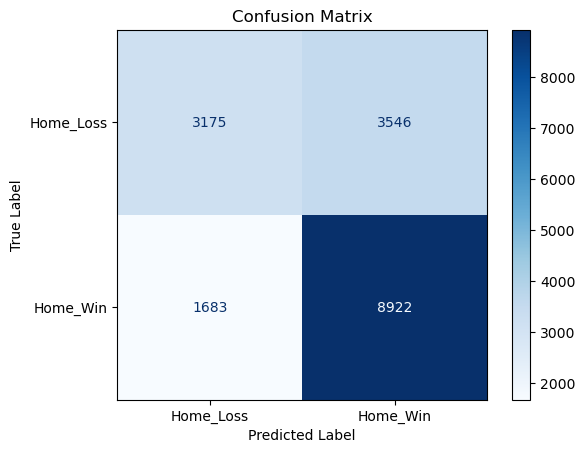

In [557]:
# confusion matrix 
def plot_cmatrix(model, X_test, y_test): 
    color = 'black'
    Labels = ['Home_Loss', 'Home_Win']
    matrix = sm.plot_confusion_matrix(model, X_test, y_test, display_labels=Labels, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix', color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()
    
plot_cmatrix(log_reg, X_test, y_test)

In [558]:
# cross validation
scores = cross_val_score(log_reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.70314259 0.69561077 0.69835498 0.69021645 0.6987013 ]
0.70 accuracy with a standard deviation of 0.00


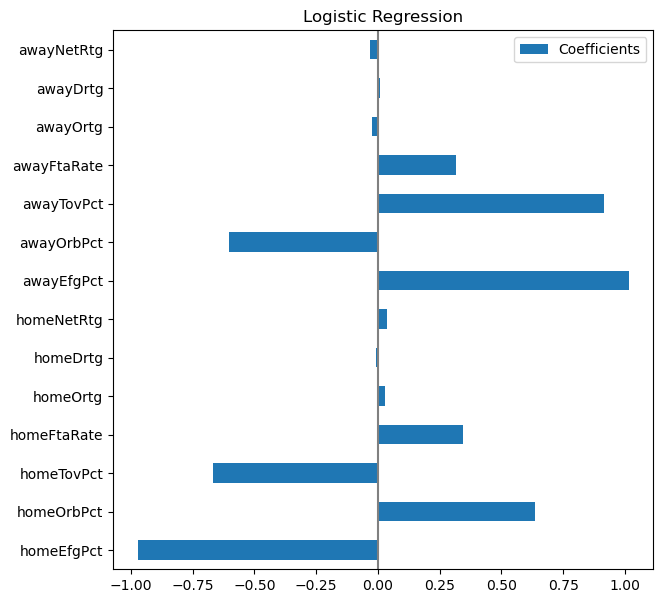

In [559]:
# feature importance 
coef_array = log_reg.coef_
coefs = pd.DataFrame(
   log_reg.coef_.reshape(len(log_reg.coef_[0]), 1), columns=['Coefficients'], index=features
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Logistic Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [560]:
# refit the logistic regression model with normalization
lr_std = make_pipeline(StandardScaler(), LogisticRegression())
lr_std.fit(X_train, y_train)
lr_std_pred = lr_std.predict(X_test)
print('accuracy: ', sm.accuracy_score(y_test, lr_std_pred))
print(classification_report(y_test,lr_std_pred))

accuracy:  0.6975643541498326
              precision    recall  f1-score   support

           0       0.65      0.47      0.55      6721
           1       0.72      0.84      0.77     10605

    accuracy                           0.70     17326
   macro avg       0.68      0.66      0.66     17326
weighted avg       0.69      0.70      0.69     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


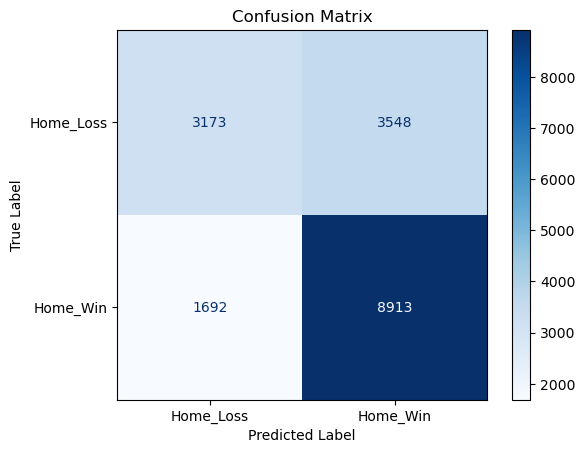

In [561]:
plot_cmatrix(lr_std, X_test, y_test)

In [562]:
# cross validation
lr_scores = cross_val_score(lr_std, X, y, cv=5)
print(lr_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (lr_scores.mean(), lr_scores.std()))

[0.70539347 0.69638992 0.69722944 0.69177489 0.6995671 ]
0.70 accuracy with a standard deviation of 0.00


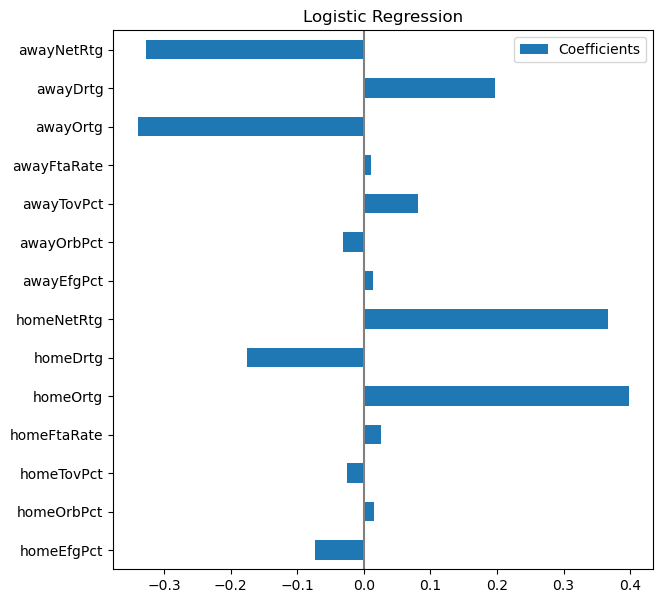

In [563]:
# feature importance 
coef_array = lr_std[1].coef_
coefs = pd.DataFrame(
   lr_std[1].coef_.reshape(len(lr_std[1].coef_[0]), 1), columns=['Coefficients'], index=features
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Logistic Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Decision Tree 

In [564]:
dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test) 
print('Accuracy: ', sm.accuracy_score(y_test, dt_pred))
print(classification_report(y_test,dt_pred))

Accuracy:  0.6064296433106314
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      6721
           1       0.68      0.67      0.67     10605

    accuracy                           0.61     17326
   macro avg       0.59      0.59      0.59     17326
weighted avg       0.61      0.61      0.61     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


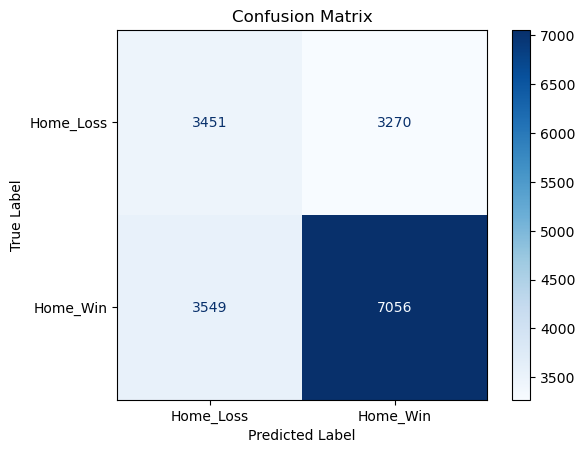

In [565]:
plot_cmatrix(dt, X_test, y_test)

In [567]:
# cross validation
dt_scores = cross_val_score(dt, X, y, cv=5)
print(dt_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_scores.mean(), dt_scores.std()))

[0.60851874 0.60436326 0.60900433 0.60155844 0.60588745]
0.61 accuracy with a standard deviation of 0.00


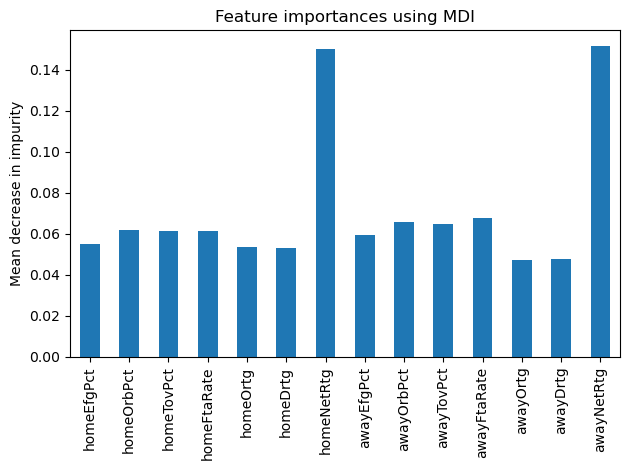

In [568]:
# feature importance 
importances = dt[1].feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Random forest

In [569]:
rf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, rf_pred))
print(classification_report(y_test,rf_pred))

Accuracy:  0.6906383469929586
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      6721
           1       0.72      0.80      0.76     10605

    accuracy                           0.69     17326
   macro avg       0.67      0.66      0.66     17326
weighted avg       0.68      0.69      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


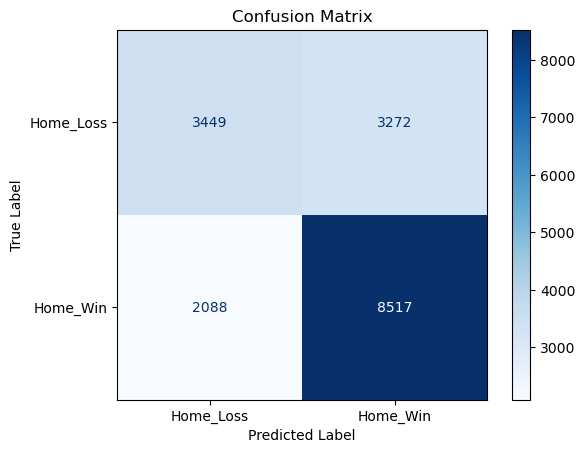

In [570]:
plot_cmatrix(rf, X_test, y_test)

In [572]:
# cross validation
rf_scores = cross_val_score(rf, X, y, cv=5)
print(rf_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_scores.mean(), rf_scores.std()))

[0.69500476 0.68781924 0.68779221 0.68735931 0.70121212]
0.69 accuracy with a standard deviation of 0.01


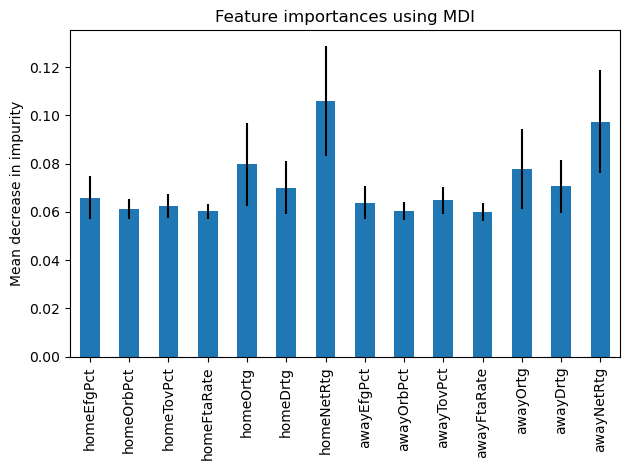

In [573]:
# feature importance 
importances = rf[1].feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf[1].estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Naive Bayes 

In [574]:
gnb = make_pipeline(StandardScaler(), GaussianNB())
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, gnb_pred))
print(classification_report(y_test,gnb_pred))

Accuracy:  0.6800761860787257
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      6721
           1       0.77      0.69      0.72     10605

    accuracy                           0.68     17326
   macro avg       0.67      0.68      0.67     17326
weighted avg       0.69      0.68      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


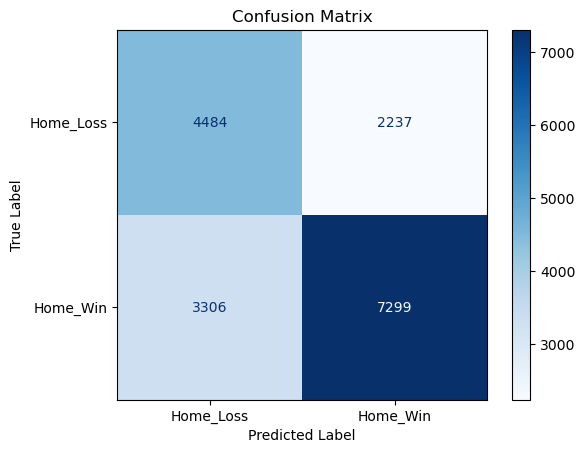

In [575]:
plot_cmatrix(gnb, X_test, y_test)

In [581]:
# cross validation
gnb_scores = cross_val_score(gnb, X, y, cv=5)
print(gnb_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (gnb_scores.mean(), gnb_scores.std()))

[0.68392347 0.67933512 0.66779221 0.68233766 0.68571429]
0.68 accuracy with a standard deviation of 0.01


### XGBoost Classifier 

In [577]:
xgb_clf = make_pipeline(StandardScaler(), xgb.XGBClassifier())
xgb_clf.fit(X_train, y_train) 
xgb_clf_pred = xgb_clf.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, xgb_clf_pred))
print(classification_report(y_test,xgb_clf_pred))

Accuracy:  0.6891954288352765
              precision    recall  f1-score   support

           0       0.62      0.52      0.56      6721
           1       0.72      0.80      0.76     10605

    accuracy                           0.69     17326
   macro avg       0.67      0.66      0.66     17326
weighted avg       0.68      0.69      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


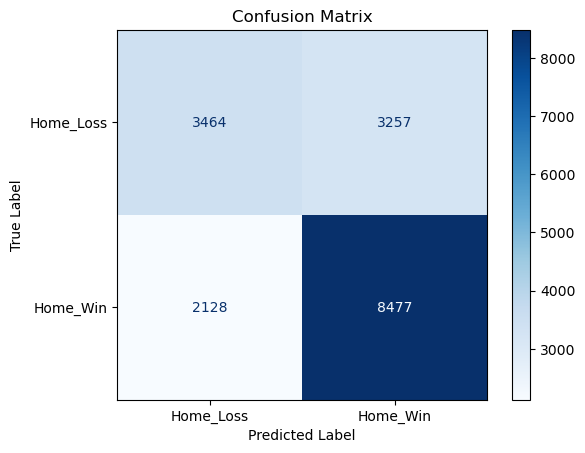

In [578]:
plot_cmatrix(xgb_clf, X_test, y_test)

In [580]:
# cross validation
xgb_scores = cross_val_score(xgb_clf, X, y, cv=5)
print(xgb_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_scores.mean(), xgb_scores.std()))

[0.69162843 0.68357718 0.68588745 0.68450216 0.69419913]
0.69 accuracy with a standard deviation of 0.00


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

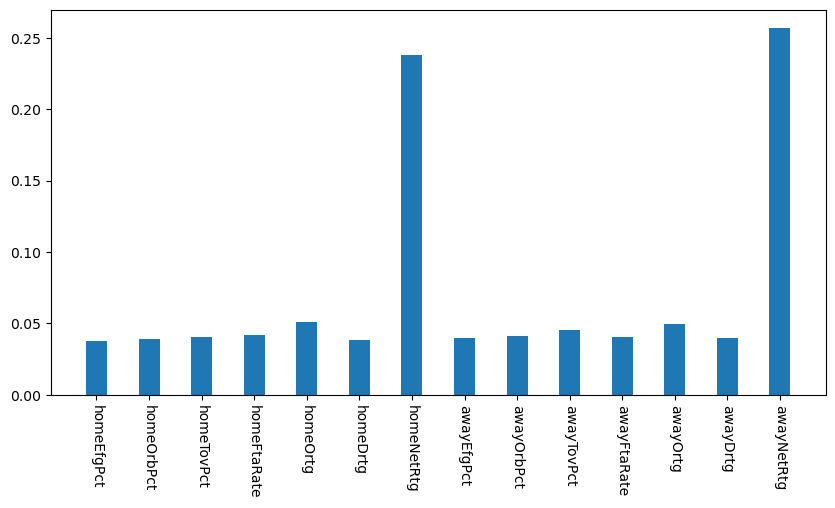

In [582]:
# feature importance 
fig = plt.figure(figsize = (10, 5))
 
important_f = xgb_clf[1].feature_importances_
plt.bar(features, important_f, 
        width = 0.4)
plt.xticks(rotation=-90)

### Support Vector Classification

In [583]:
svc = make_pipeline(StandardScaler(), SVC())
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, svc_pred))
print(classification_report(y_test,svc_pred))

Accuracy:  0.6972180537919889
              precision    recall  f1-score   support

           0       0.66      0.45      0.53      6721
           1       0.71      0.86      0.78     10605

    accuracy                           0.70     17326
   macro avg       0.69      0.65      0.66     17326
weighted avg       0.69      0.70      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


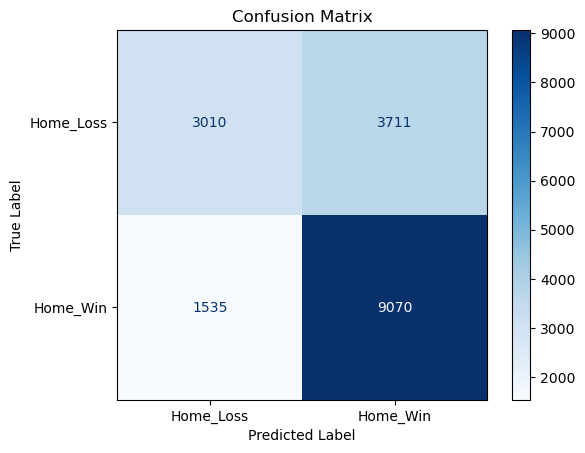

In [584]:
plot_cmatrix(svc, X_test, y_test)

In [585]:
# cross validation
svc_scores = cross_val_score(svc, X, y, cv=5)
print(svc_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (svc_scores.mean(), svc_scores.std()))

[0.70201714 0.69448533 0.69835498 0.69298701 0.70233766]
0.70 accuracy with a standard deviation of 0.00


## Neural Network

## Classification (4 factors + rtg difference between teams)

### Features 

In [586]:
df['EfgPctDiff'] = df['homeEfgPct'] - df['awayEfgPct'] 
df['OrbPctDiff'] = df['homeOrbPct'] - df['awayOrbPct'] 
df['TovPctDiff'] = df['homeTovPct'] - df['awayTovPct'] 
df['FtaRateDiff'] = df['homeFtaRate'] - df['awayFtaRate'] 
df['OrtgDiff'] = df['homeOrtg'] - df['awayOrtg'] 
df['DrtgDiff'] = df['homeDrtg'] - df['awayDrtg'] 
df['NetRtgDiff'] = df['homeNetRtg'] - df['awayNetRtg'] 
df.head()

,gameId,gameDate,homeId,awayId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,homeGp,...,awayNetRtg,pointsDiff,result,EfgPctDiff,OrbPctDiff,TovPctDiff,FtaRateDiff,OrtgDiff,DrtgDiff,NetRtgDiff
4,1007934,2018-11-03,103271,103292,Alas. Anchorage,Antelope Valley,73.0,65.0,True,1.0,...,-13.08364,8.0,1,0.10000,0.02792,-0.03634,-0.03333,13.08364,-13.08364,26.16728
5,1007962,2018-11-03,103578,103319,Embry-Riddle (FL),Azusa Pacific,79.0,70.0,True,1.0,...,-22.12155,9.0,1,0.08632,0.26486,0.05517,0.22702,20.18926,-6.28761,26.47687
9,1007932,2018-11-03,103547,103494,Drury,CUI,62.0,65.0,False,1.0,...,-4.35532,-3.0,0,-0.04615,0.00224,0.07314,-0.12264,-20.24524,-16.86568,-3.37956
10,1007916,2018-11-03,104446,103819,West Tex. A&M,Lindenwood,65.0,62.0,True,1.0,...,22.12155,3.0,1,-0.11111,-0.07479,0.01724,0.11991,-18.79797,-4.41130,-14.38667
12,1007996,2018-11-04,104017,103602,Northwest Mo. St.,Ferris St.,100.0,86.0,True,1.0,...,2.49539,14.0,1,-0.10098,0.18927,-0.06837,-0.12157,5.62723,5.26297,0.36426


In [587]:
features_diff = ['EfgPctDiff', 'OrbPctDiff', 'TovPctDiff', 'FtaRateDiff',
       'OrtgDiff', 'DrtgDiff', 'NetRtgDiff'] 
X = X = df[features_diff]
y = df['result'] 

# split into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

### Logistic Regression

In [588]:
lr_std = make_pipeline(StandardScaler(), LogisticRegression())
lr_std.fit(X_train, y_train)
lr_std_pred = lr_std.predict(X_test)
print('accuracy: ', sm.accuracy_score(y_test, lr_std_pred))
print(classification_report(y_test,lr_std_pred))

accuracy:  0.6973334872446035
              precision    recall  f1-score   support

           0       0.65      0.47      0.55      6721
           1       0.72      0.84      0.77     10605

    accuracy                           0.70     17326
   macro avg       0.68      0.66      0.66     17326
weighted avg       0.69      0.70      0.69     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


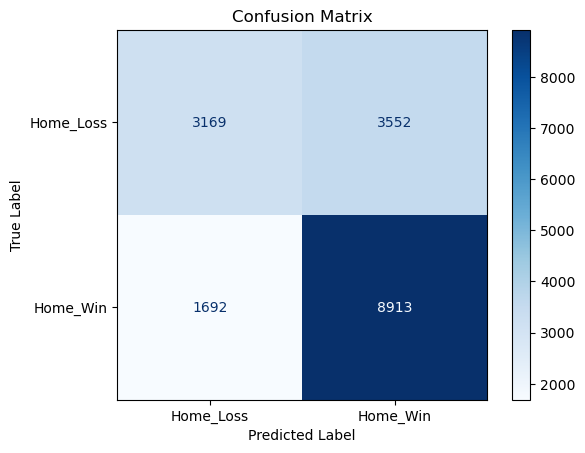

In [589]:
plot_cmatrix(lr_std, X_test, y_test)

In [590]:
# cross validation
lr_scores = cross_val_score(lr_std, X, y, cv=5)
print(lr_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (lr_scores.mean(), lr_scores.std()))

[0.70357545 0.69535105 0.69731602 0.69056277 0.70025974]
0.70 accuracy with a standard deviation of 0.00


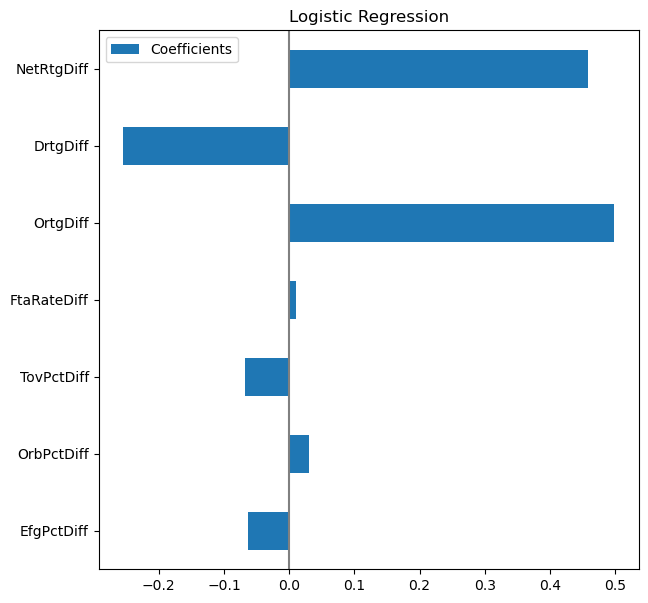

In [591]:
# feature importance 
coef_array = lr_std[1].coef_
coefs = pd.DataFrame(
   lr_std[1].coef_.reshape(len(lr_std[1].coef_[0]), 1), columns=['Coefficients'], index=features_diff
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Logistic Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Decision Tree 

In [592]:
dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test) 
print('Accuracy: ', sm.accuracy_score(y_test, dt_pred))
print(classification_report(y_test,dt_pred))

Accuracy:  0.6071799607526261
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      6721
           1       0.68      0.67      0.68     10605

    accuracy                           0.61     17326
   macro avg       0.59      0.59      0.59     17326
weighted avg       0.61      0.61      0.61     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


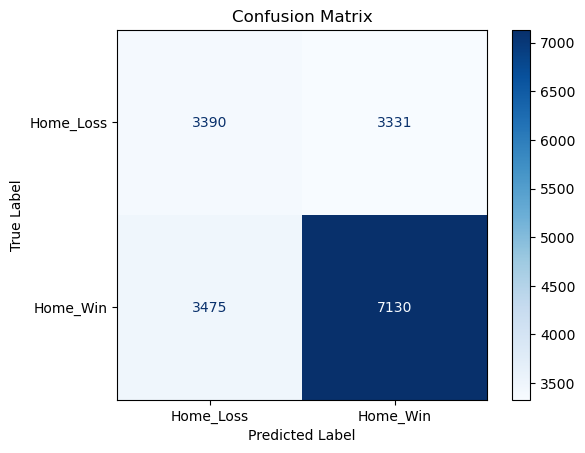

In [593]:
plot_cmatrix(dt, X_test, y_test)

In [594]:
# cross validation
dt_scores = cross_val_score(dt, X, y, cv=5)
print(dt_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_scores.mean(), dt_scores.std()))

[0.60263181 0.60955761 0.59965368 0.60181818 0.61125541]
0.60 accuracy with a standard deviation of 0.00


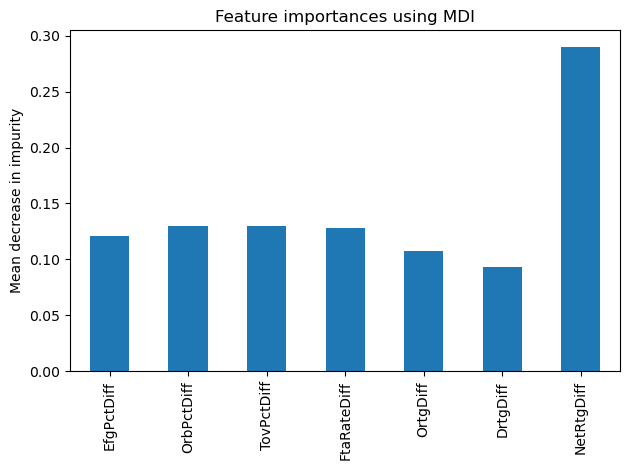

In [595]:
# feature importance 
importances = dt[1].feature_importances_
forest_importances = pd.Series(importances, index=features_diff)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Random Forest

In [596]:
rf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, rf_pred))
print(classification_report(y_test,rf_pred))

Accuracy:  0.681172803878564
              precision    recall  f1-score   support

           0       0.60      0.51      0.56      6721
           1       0.72      0.79      0.75     10605

    accuracy                           0.68     17326
   macro avg       0.66      0.65      0.65     17326
weighted avg       0.67      0.68      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


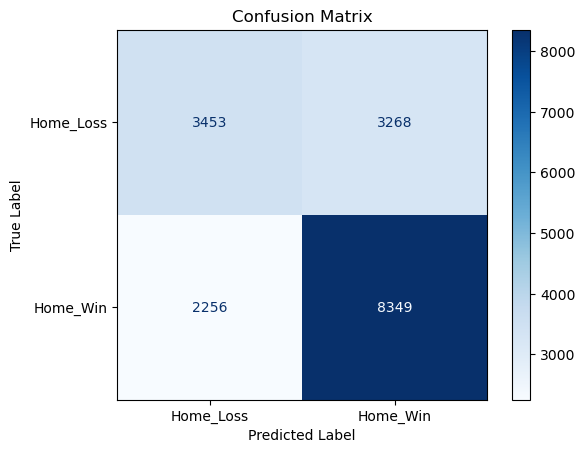

In [597]:
plot_cmatrix(rf, X_test, y_test)

In [598]:
# cross validation
rf_scores = cross_val_score(rf, X, y, cv=5)
print(rf_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_scores.mean(), rf_scores.std()))

[0.68305774 0.67448706 0.68571429 0.6804329  0.68761905]
0.68 accuracy with a standard deviation of 0.00


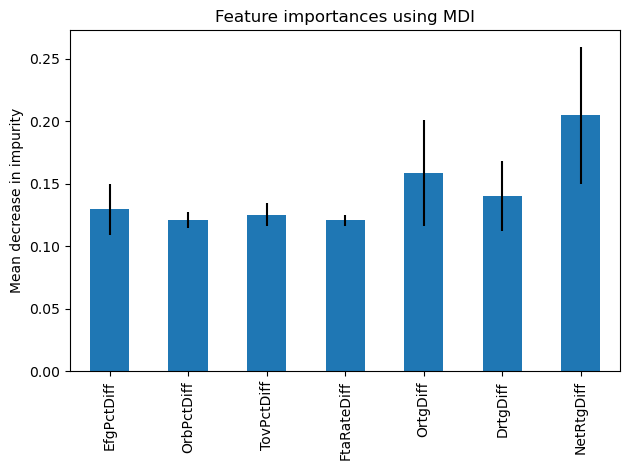

In [599]:
# feature importance 
importances = rf[1].feature_importances_
forest_importances = pd.Series(importances, index=features_diff)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf[1].estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Naive Bayes 

In [600]:
gnb = make_pipeline(StandardScaler(), GaussianNB())
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, gnb_pred))
print(classification_report(y_test,gnb_pred))

Accuracy:  0.683019739120397
              precision    recall  f1-score   support

           0       0.58      0.68      0.63      6721
           1       0.77      0.68      0.73     10605

    accuracy                           0.68     17326
   macro avg       0.67      0.68      0.68     17326
weighted avg       0.70      0.68      0.69     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


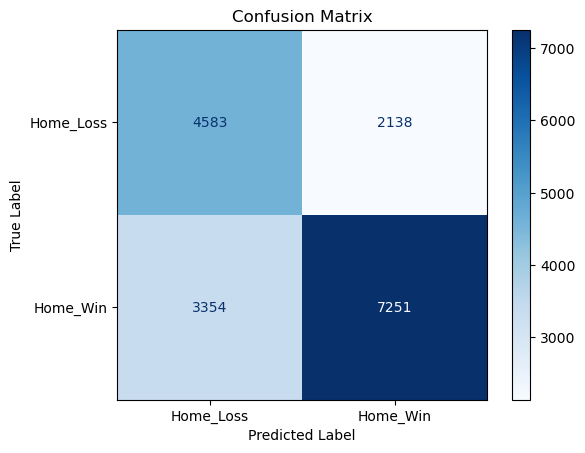

In [601]:
plot_cmatrix(gnb, X_test, y_test)

In [602]:
# cross validation
gnb_scores = cross_val_score(gnb, X, y, cv=5)
print(gnb_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (gnb_scores.mean(), gnb_scores.std()))

[0.6838369  0.68037399 0.67471861 0.68424242 0.68822511]
0.68 accuracy with a standard deviation of 0.00


### XGBoost Classifier 

In [603]:
xgb_clf = make_pipeline(StandardScaler(), xgb.XGBClassifier())
xgb_clf.fit(X_train, y_train) 
xgb_clf_pred = xgb_clf.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, xgb_clf_pred))
print(classification_report(y_test,xgb_clf_pred))

Accuracy:  0.6906960637192658
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      6721
           1       0.72      0.81      0.76     10605

    accuracy                           0.69     17326
   macro avg       0.67      0.66      0.66     17326
weighted avg       0.68      0.69      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


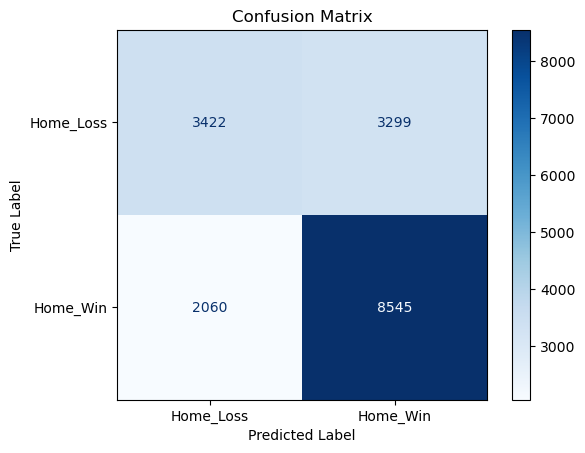

In [604]:
plot_cmatrix(xgb_clf, X_test, y_test)

In [605]:
# cross validation
xgb_scores = cross_val_score(xgb_clf, X, y, cv=5)
print(xgb_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_scores.mean(), xgb_scores.std()))

[0.69145529 0.6847892  0.68865801 0.68857143 0.69489177]
0.69 accuracy with a standard deviation of 0.00


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

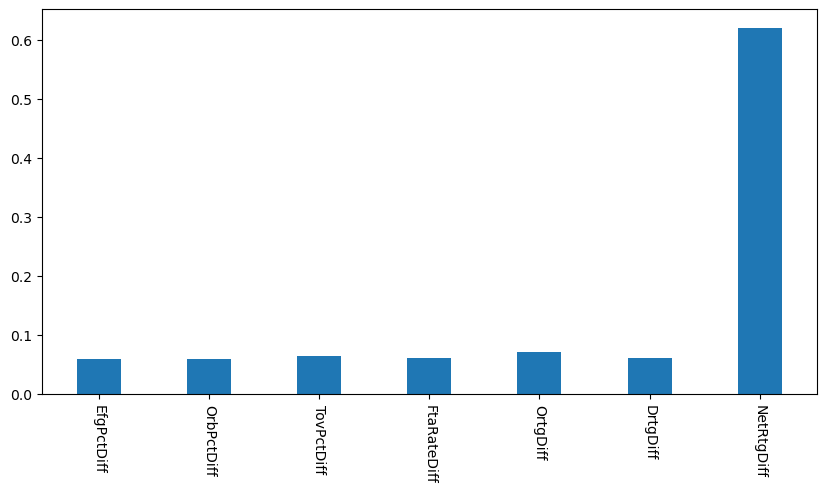

In [606]:
# feature importance 
fig = plt.figure(figsize = (10, 5))
 
important_f = xgb_clf[1].feature_importances_
plt.bar(features_diff, important_f, 
        width = 0.4)
plt.xticks(rotation=-90)

### Support Vector Classification

In [607]:
svc = make_pipeline(StandardScaler(), SVC())
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('Accuracy: ', sm.accuracy_score(y_test, svc_pred))
print(classification_report(y_test,svc_pred))

Accuracy:  0.6968140367078379
              precision    recall  f1-score   support

           0       0.65      0.47      0.54      6721
           1       0.71      0.84      0.77     10605

    accuracy                           0.70     17326
   macro avg       0.68      0.65      0.66     17326
weighted avg       0.69      0.70      0.68     17326



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


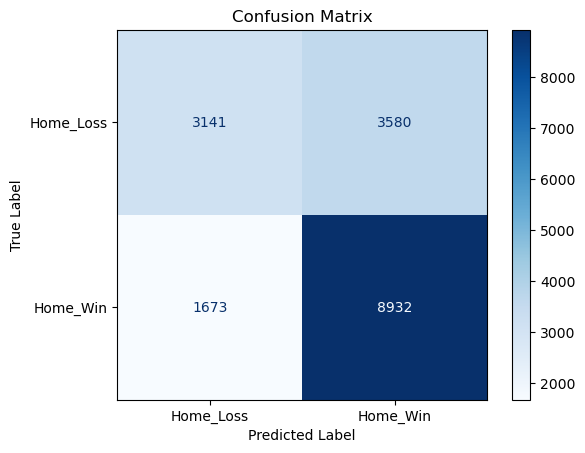

In [610]:
plot_cmatrix(svc, X_test, y_test)

In [611]:
# cross validation
svc_scores = cross_val_score(svc, X, y, cv=5)
print(svc_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (svc_scores.mean(), svc_scores.std()))

[0.70245    0.69604363 0.69818182 0.69021645 0.70103896]
0.70 accuracy with a standard deviation of 0.00


## Regression to predict point differential

### Features and Label 

In [528]:
features

['homeEfgPct',
 'homeOrbPct',
 'homeTovPct',
 'homeFtaRate',
 'homeOrtg',
 'homeDrtg',
 'homeNetRtg',
 'awayEfgPct',
 'awayOrbPct',
 'awayTovPct',
 'awayFtaRate',
 'awayOrtg',
 'awayDrtg',
 'awayNetRtg']

In [529]:
X = df[features] 
y = df['pointsDiff'] 
# split into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

### Linear Regression

In [530]:
lin_reg = make_pipeline(StandardScaler(), LinearRegression())
lin_reg.fit(X_train, y_train) 
lin_reg_pred = lin_reg.predict(X_test) 
print('r2: ', sm.r2_score(y_test, lin_reg_pred))
print('RMSE: ', sm.mean_squared_error(y_test, lin_reg_pred, squared=False))

r2:  0.2665005296954812
RMSE:  14.996448743774133


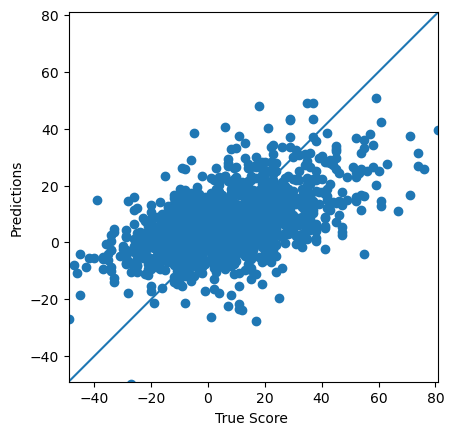

In [535]:
# visualize predictions 
def plot_predictions(y_test, pred): 
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, pred)
    plt.xlabel('True Score ')
    plt.ylabel('Predictions')
    lims = [y_test.min(), y_test.max()]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
plot_predictions(y_test, lin_reg_pred)

### SVM Regressor 

In [531]:
svr = make_pipeline(StandardScaler(), SVR())
svr.fit(X_train, y_train) 
svr_pred = svr.predict(X_test) 
print('r2: ', sm.r2_score(y_test, svr_pred))
print('RMSE: ', sm.mean_squared_error(y_test, svr_pred, squared=False))

r2:  0.2544968067713256
RMSE:  15.118659262533788


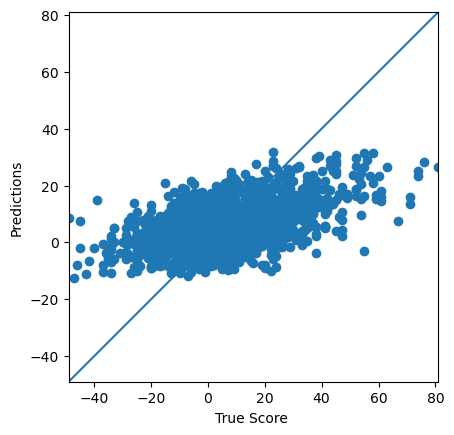

In [536]:
plot_predictions(y_test, svr_pred)